<a href="https://colab.research.google.com/github/verma-saloni/Thesis-Alternate-Commits/blob/master/04_28_22_1_GosGloVe50D_Conv1d_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First we import the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf

from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = Path("/content/drive/MyDrive/")
assert base_dir.exists()

Mounted at /content/drive


Fake 0
Real 1

In [3]:
df_fake = pd.read_csv(base_dir/'gossipcop_fake.csv')
df_real = pd.read_csv(base_dir/'gossipcop_real.csv')
df_fake['labelML']=0
df_real['labelML']=1

In [4]:
news= df_fake.append(df_real)
news.reset_index(drop=True, inplace=True)

In [5]:
# news_dummies = pd.get_dummies(news.labelML)
# news = pd.concat([news, news_dummies], axis=1)

In [6]:
news.head()

,id,news_url,title,tweet_ids,labelML
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,0
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,0
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,0
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,0


In [7]:
news.tail()

,id,news_url,title,tweet_ids,labelML
22135,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1
22136,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1
22137,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1
22138,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1
22139,gossipcop-877062,https://www.cosmopolitan.com/uk/entertainment/...,Kylie Jenner is actually terrified of butterflies,NaN,1


In [8]:
news = news.drop(['tweet_ids', 'news_url','id'], axis=1)

assert not news.isna().any().any()
news.count()

title      22140
labelML    22140
dtype: int64

In [9]:
news.dtypes

title      object
labelML     int64
dtype: object

In [10]:
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news['title']= news['title'].apply(denoise_text)

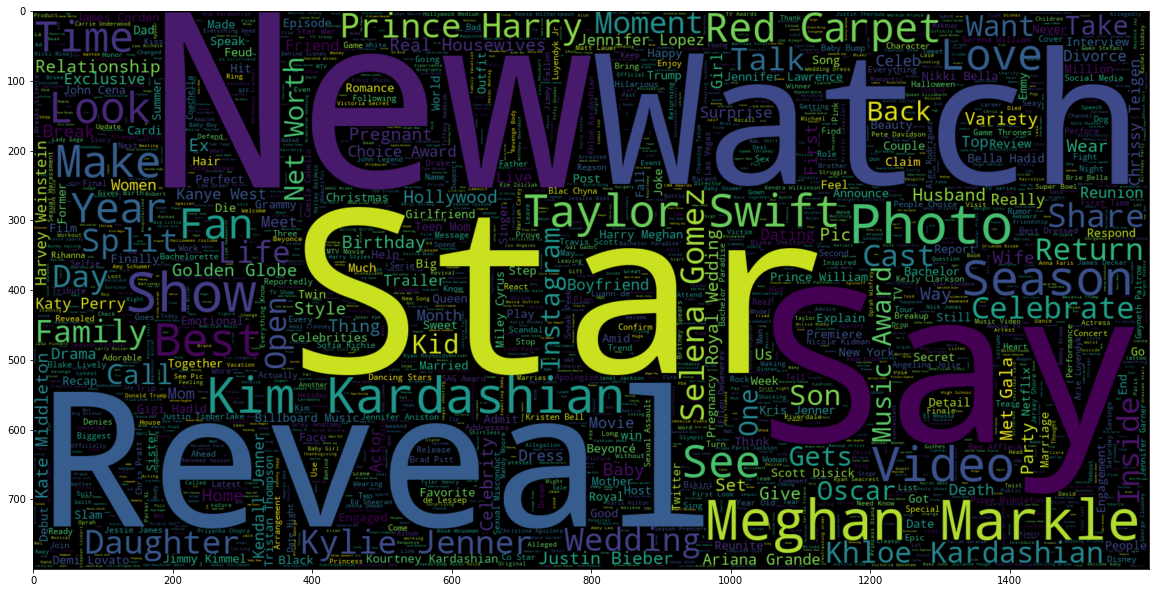

In [12]:
#WORDCLOUD FOR REAL TEXT (LABEL - 1)
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.labelML == 1].title))
plt.imshow(wc , interpolation = 'bilinear');

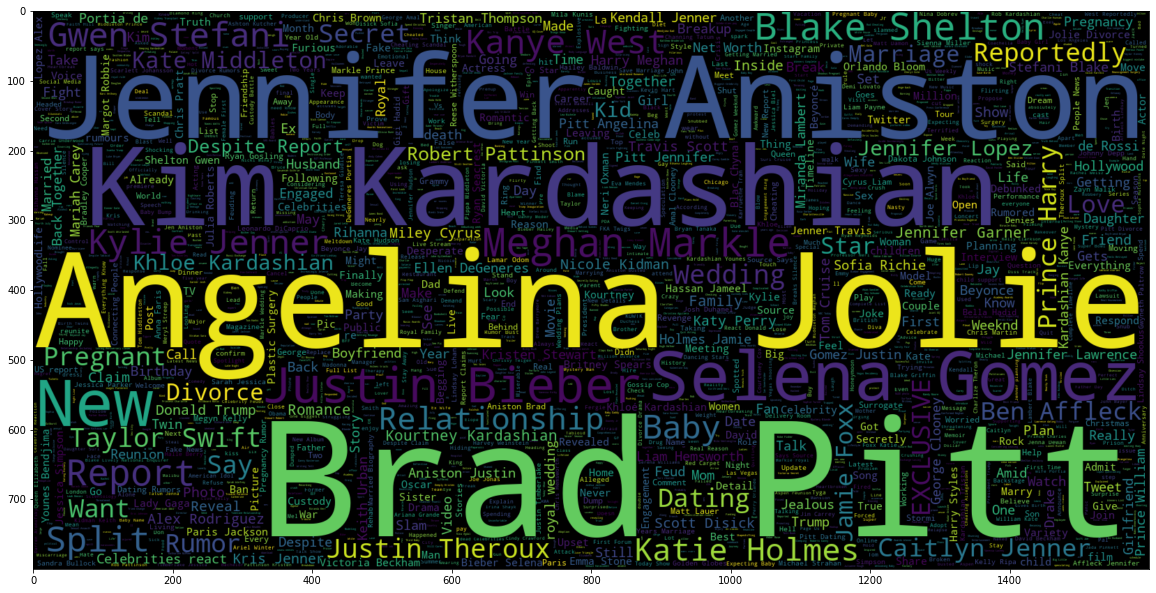

In [13]:
#WORDCLOUD FOR Fake TEXT (LABEL - 0)
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.labelML == 0].title))
plt.imshow(wc , interpolation = 'bilinear');

In [14]:
#Splitting the data into 2 parts - training and testing data
X_train, X_test,y_train,y_test = train_test_split(news.title,news.labelML,test_size=0.3,random_state=42)
# max_features = 3281
# maxlen = 3281

In [15]:
#Tokenizing Text -> Repsesenting each word by a number
tokenizer = text.Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)

# x_train = sequence.pad_sequences()
#maxlen should be the longest sequence that we have, padding comes upto that length. 
#mask_0=True add to the embedding layer. so that the 0 mask is ignored. 
#after embedding add another layer that does the mean .. tf.keras.layers.Average. to find the average. conf2d and pooling not needed. 

In [16]:
max_len = max(map(len, tokenized_train))

In [17]:
max(tokenizer.word_index.values())

19268

In [18]:
X_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [19]:
#Glove
EMBEDDING_FILE = '/content/drive/MyDrive/glove.6B.50d.txt'

In [20]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [21]:
len(embeddings_index['question'])

50

from tensorflow.python.ops.array_ops import zeros
from pandas.core.arrays.sparse import array
1. form an empty list, holds embedding confusion_matrix
.. add empty array to array of zeros- padding token
2. iterate from smaller toekn no to biggest token no 0....n, token[0]=empty array
3. for each no, find what is the word and look it up in the all_embs, then append to embedding emb matrix


In [22]:
emb_matrix=list()
emb_matrix.append(np.zeros(50,dtype=np.float32))
for i in range(1,max(tokenizer.word_index.values())+1):
  word = tokenizer.index_word[i]
  if word not in embeddings_index:
    emb_matrix.append(np.zeros(50,dtype=np.float32))
  else: 
    emb_matrix.append(embeddings_index[word]) 

In [23]:
emb_matrix[:3]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([ 1.9511e-01,  5.0739e-01,  1.4709e-03,  4.1914e-02, -1.6759e-01,
         3.7517e-02, -1.3970e+00, -9.2398e-01, -2.4296e-01, -1.5171e-01,
        -4.7829e-01,  5.4612e-02, -2.4986e-01,  3.8398e-01,  1.6182e-02,
         3.4938e-01, -2.2627e-01,  8.6618e-02, -4.1001e-01, -1.8139e-01,
         7.5607e-01, -2.6200e-02, -6.9557e-01,  1.0874e-01, -4.7539e-01,
        -1.8095e+00, -1.6940e-01, -5.9863e-02, -1.6806e-01, -9.4546e-02,
         3.6610e+00,  4.1462e-02, -2.9161e-01, -6.9772e-01,  3.080

In [24]:
emb_matrix = np.stack(emb_matrix, axis=0)
emb_matrix.shape

(19269, 50)

In [25]:
batch_size = 256
epochs = 100
# tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)

In [28]:
#with Gabriel
#Defining Neural Network
# model = Sequential()
#Non-trainable embeddidng layer
# model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
# model.add(LSTM(units=128 , return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64))
# model.add(Dropout(0.1))
# model.add(Dense(units = 32 , activation = 'relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# emb_matrix2 = np.array(emb_matrix)
#Hybrid Neural Network


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(emb_matrix.shape[0], output_dim=emb_matrix.shape[1], weights=[emb_matrix],trainable=False, mask_zero=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='softmax'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [29]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          963450    
                                                                 
 dropout_3 (Dropout)         (None, None, 50)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         32128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, None, 20)          11920     
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                      

In [31]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test, y_test), epochs=epochs)

Epoch 1/100
61/61 [==============================] - 17s 36ms/step - loss: 0.5629 - accuracy: 0.7547 - val_loss: 0.5453 - val_accuracy: 0.7632
Epoch 2/100
61/61 [==============================] - 1s 18ms/step - loss: 0.5200 - accuracy: 0.7648 - val_loss: 0.4990 - val_accuracy: 0.7805
Epoch 3/100
61/61 [==============================] - 1s 17ms/step - loss: 0.4827 - accuracy: 0.7797 - val_loss: 0.4641 - val_accuracy: 0.7954
Epoch 4/100
61/61 [==============================] - 1s 17ms/step - loss: 0.4556 - accuracy: 0.7940 - val_loss: 0.4650 - val_accuracy: 0.8037
Epoch 5/100
61/61 [==============================] - 1s 18ms/step - loss: 0.4361 - accuracy: 0.8048 - val_loss: 0.4435 - val_accuracy: 0.8028
Epoch 6/100
61/61 [==============================] - 1s 17ms/step - loss: 0.4211 - accuracy: 0.8105 - val_loss: 0.4285 - val_accuracy: 0.8144
Epoch 7/100
61/61 [==============================] - 1s 17ms/step - loss: 0.4004 - accuracy: 0.8245 - val_loss: 0.4236 - val_accuracy: 0.8232
Epoch

In [32]:
model.evaluate(X_train,y_train)
model.evaluate(X_test,y_test)

208/208 [==============================] - 1s 5ms/step - loss: 0.7888 - accuracy: 0.7925


[0.7888139486312866, 0.7925323843955994]

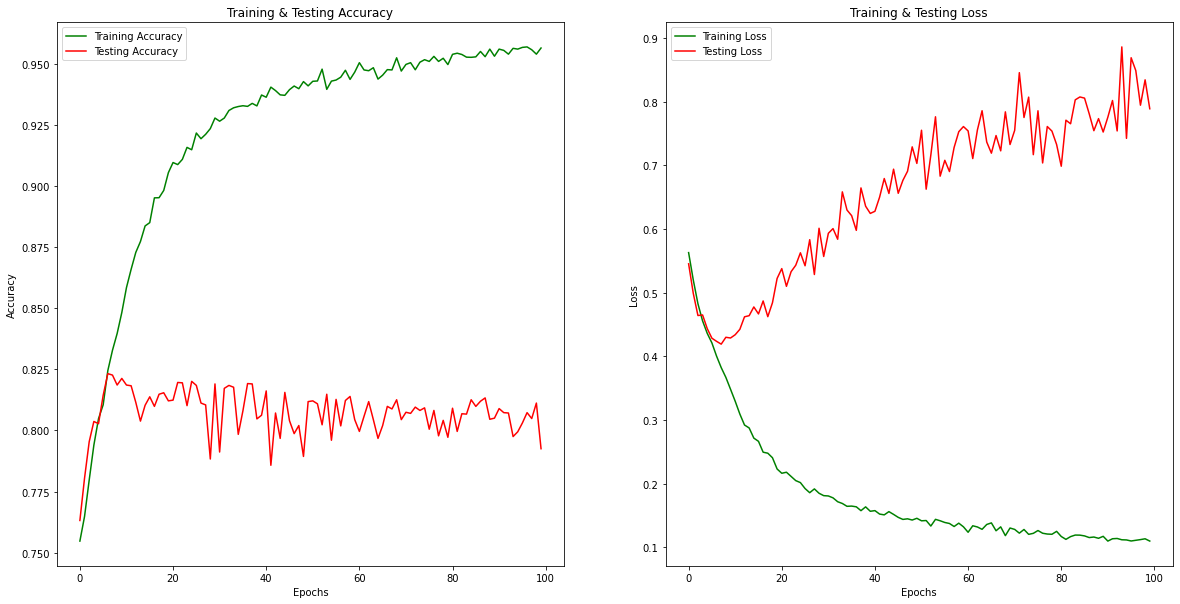

In [33]:
epoch_list = [i for i in range(0,epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epoch_list , train_acc , 'g-' , label = 'Training Accuracy')
ax[0].plot(epoch_list , val_acc , 'r-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epoch_list , train_loss , 'g-' , label = 'Training Loss')
ax[1].plot(epoch_list , val_loss , 'r-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [34]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Final layer has sigmoid activation. If pred < 0.5 class is 0 (Fake), else 1 (Real)

In [35]:
pred_train_classes = (pred_train > 0.5).astype(int)
pred_test_classes = (pred_test > 0.5).astype(int)

In [36]:
(pred_train_classes.squeeze() == y_train).mean(), (pred_test_classes.squeeze() == y_test).mean()

(0.9807071880242612, 0.7925323697681421)

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

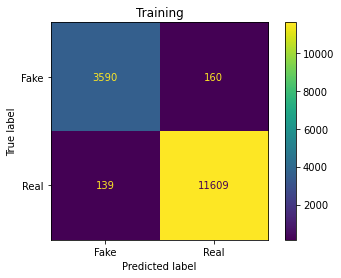

In [38]:
cmdisp = ConfusionMatrixDisplay.from_predictions(y_train, pred_train_classes, display_labels=["Fake", "Real"])
cmdisp.ax_.set_title("Training")
plt.show()

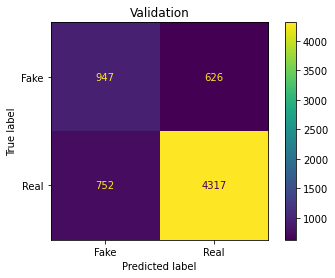

In [39]:
cmdisp = ConfusionMatrixDisplay.from_predictions(y_test, pred_test_classes, display_labels=["Fake", "Real"])
cmdisp.ax_.set_title("Validation")
plt.show()

In [40]:
from collections import Counter


print(Counter(y_test).keys()) # equals to list(set(words))
print(Counter(y_test).values())

dict_keys([1, 0])
dict_values([5069, 1573])


In [41]:
sentence = ["All the universities and schools remain closed for two months due to the corona virus outbreak in the country."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = sequence.pad_sequences(sequences, maxlen=max_len)
model_decision = model.predict(padded)
print(model_decision)

[[0.7509723]]


In [42]:
sentence1 = ["leeee keen to nooo where leaves"]
sequences1 = tokenizer.texts_to_sequences(sentence)
padded1 = sequence.pad_sequences(sequences1, maxlen=max_len)
model_decision1 = model.predict(padded1)
print(model_decision1)

[[0.7509723]]
